In [11]:
import numpy as np
import pandas as pd
import itertools
import shutil
from PIL import Image
import os

import torch
from torch import nn, utils, optim
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, content="train"):
        self.transform = transform
        self.images = []
        self.labels = []
        
        self.root = root
        
        names = ["ichika", "nino", "miku", "yotsuba", "itsuki"]
        for i, name in enumerate(names):
            if content == "train":
                path = os.path.join(self.root, "train", name)
            elif content == "val":
                path = os.path.join(self.root, "valid", name)
            else:
                path = os.path.join(self.root, "test", name)
                
            images = os.listdir(path)
            labels = [i] * len(images)
            for image, label in zip(images, labels):
                self.images.append(os.path.join(path, image))
                self.labels.append(label)
                
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        with open(image, "rb") as f:
            image = Image.open(image)
            image = image.convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.images)

In [13]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.ColorJitter(brightness=0.4),
        transforms.RandomGrayscale(0.1),
        transforms.ToTensor(),
        transforms.RandomErasing(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
           std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
}
to_tensor_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

In [14]:
train_dataset = CustomDataset("gotobunnohanayome", data_transforms["train"], content="train")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_dataset = CustomDataset("gotobunnohanayome", data_transforms["val"], content="val")
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [6]:
USE_DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [7]:
model = models.densenet121(pretrained=True)
model = model.to(USE_DEVICE)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 5).to(USE_DEVICE)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [25]:
num_epochs = 50

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

if not os.path.exists("gotobunnohanayome/tmp"):
    os.mkdir("gotobunnohanayome/tmp")
if not os.path.exists("gotobunnohanayome/params"):
    os.mkdir("gotobunnohanayome/params")
    
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    model.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(USE_DEVICE), labels.to(USE_DEVICE)
      
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    model.eval()
    with torch.no_grad():
      for images, labels in val_loader:
        images = images.to(USE_DEVICE)
        labels = labels.to(USE_DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr：{learning_rate}' 
                       .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, learning_rate=optimizer.param_groups[0]["lr"]))
    #学習率調整
    lr_scheduler.step()
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    
    torch.save(model.state_dict(), f"gotobunnohanayome/tmp/checkpoint{epoch}.pth")
    
best_epoch = np.argmax(val_acc_list)
shutil.copyfile(f"gotobunnohanayome/tmp/checkpoint{best_epoch}.pth", "gotobunnohanayome/params/model1.pth")
shutil.rmtree("gotobunnohanayome/tmp")

Epoch [1/50], Loss: 0.0723, val_loss: 1.0368, val_acc: 0.4108, lr：0.01
Epoch [2/50], Loss: 0.0743, val_loss: 1.0590, val_acc: 0.5516, lr：0.01
Epoch [3/50], Loss: 0.0718, val_loss: 0.2471, val_acc: 0.8357, lr：0.01
Epoch [4/50], Loss: 0.0431, val_loss: 0.2358, val_acc: 0.8521, lr：0.01
Epoch [5/50], Loss: 0.0394, val_loss: 0.1381, val_acc: 0.9085, lr：0.01
Epoch [6/50], Loss: 0.0289, val_loss: 0.0847, val_acc: 0.9225, lr：0.01
Epoch [7/50], Loss: 0.0261, val_loss: 0.0917, val_acc: 0.9038, lr：0.01
Epoch [8/50], Loss: 0.0204, val_loss: 0.0585, val_acc: 0.9531, lr：0.01
Epoch [9/50], Loss: 0.0205, val_loss: 0.0448, val_acc: 0.9554, lr：0.01
Epoch [10/50], Loss: 0.0142, val_loss: 0.0407, val_acc: 0.9695, lr：0.001
Epoch [11/50], Loss: 0.0110, val_loss: 0.0402, val_acc: 0.9765, lr：0.001
Epoch [12/50], Loss: 0.0122, val_loss: 0.0378, val_acc: 0.9742, lr：0.001
Epoch [13/50], Loss: 0.0095, val_loss: 0.0407, val_acc: 0.9742, lr：0.001
Epoch [14/50], Loss: 0.0101, val_loss: 0.0389, val_acc: 0.9742, lr：0.

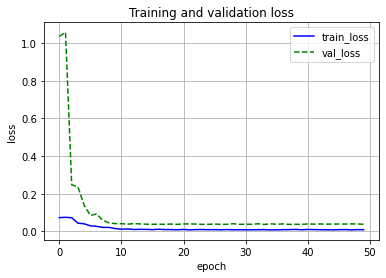

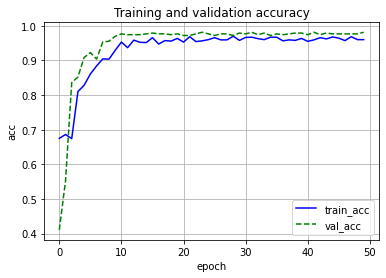

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

In [9]:
test_dataset = CustomDataset("gotobunnohanayome", data_transforms["val"], content="test")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [10]:
model = models.densenet121(pretrained=False)
model = model.to(USE_DEVICE)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 5).to(USE_DEVICE)
model.load_state_dict(torch.load("gotobunnohanayome/params/model1.pth", map_location=torch.device(USE_DEVICE)))
model.eval()
test_loss = 0
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(USE_DEVICE)
        labels = labels.to(USE_DEVICE)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()
avg_test_loss = test_loss / len(test_loader.dataset)
avg_test_acc = test_acc / len(test_loader.dataset)

print ("test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}"
                       .format(test_loss=avg_test_loss, test_acc=avg_test_acc))

test_loss: 0.0285, test_acc: 0.9730
